# Background
The dataset consists of web data scrapped from imdb.com. The dataset contains numerous movie attributes such as the title, name of the director, facebook likes, budgets and revenues etc. 

# Objective
To compare and contrast different machine learning and deep learning models that will predict the IMDB ratings

In [62]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
tf.logging.set_verbosity(tf.logging.ERROR)

In [2]:
imdb = pd.read_csv('movie_metadata.csv')
imdb.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


In [3]:
imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 28 columns):
color                        5024 non-null object
director_name                4939 non-null object
num_critic_for_reviews       4993 non-null float64
duration                     5028 non-null float64
director_facebook_likes      4939 non-null float64
actor_3_facebook_likes       5020 non-null float64
actor_2_name                 5030 non-null object
actor_1_facebook_likes       5036 non-null float64
gross                        4159 non-null float64
genres                       5043 non-null object
actor_1_name                 5036 non-null object
movie_title                  5043 non-null object
num_voted_users              5043 non-null int64
cast_total_facebook_likes    5043 non-null int64
actor_3_name                 5020 non-null object
facenumber_in_poster         5030 non-null float64
plot_keywords                4890 non-null object
movie_imdb_link              5043 non-

# Feature Engineering

### The features that have only one unique value will be removed since they don't add any information to imdb scores

In [4]:
drop_labels = ['director_name', 'actor_2_name', 'actor_1_name', 'movie_title', 
               'actor_3_name', 'plot_keywords', 'movie_imdb_link', 'title_year', 'country']
imdb.drop(drop_labels, axis = 1, inplace = True)

### "Unbundling" the *genres* variable 

In [5]:
genre_series = pd.Series([each.split('|') for each in imdb['genres']])
imdb['new_genre'] =pd.DataFrame(genre_series)

### one-hot encoding the various genres

In [6]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
imdb = imdb.join(pd.DataFrame(mlb.fit_transform(imdb.pop('new_genre')), columns=mlb.classes_, index=imdb.index))
imdb.drop(labels='genres', axis = 1, inplace = True)
imdb.head()

,color,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,...,Mystery,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
0,Color,723.0,178.0,0.0,855.0,1000.0,760505847.0,886204,4834,0.0,...,0,0,0,0,1,0,0,0,0,0
1,Color,302.0,169.0,563.0,1000.0,40000.0,309404152.0,471220,48350,0.0,...,0,0,0,0,0,0,0,0,0,0
2,Color,602.0,148.0,0.0,161.0,11000.0,200074175.0,275868,11700,1.0,...,0,0,0,0,0,0,0,1,0,0
3,Color,813.0,164.0,22000.0,23000.0,27000.0,448130642.0,1144337,106759,0.0,...,0,0,0,0,0,0,0,1,0,0
4,NaN,NaN,NaN,131.0,NaN,131.0,NaN,8,143,0.0,...,0,0,0,0,0,0,0,0,0,0


### One-hot encoding the feature *color*. A value of 1 represents *Color* and a value of 0 represents *black and white*

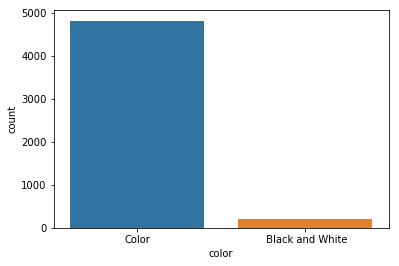

In [7]:
sns.countplot(imdb['color'])
plt.show()

In [8]:
imdb['color'] = imdb['color'].map({'Color': 1, ' Black and White': 0})

### Encoding the language column into binary classification. English language films will be encoded as value 1 and non-english language films will be encoded as value 0

In [9]:
def language_binary(column):
        if column == 'English':
            column = 1
            return column
        else:
            column = 0
            return column

imdb['language'] = imdb['language'].apply(language_binary)

### one hot encoding of content_rating; Only the popular movie ratings will be considered for classification and the remaining ratings, which are predominantly TV ratings, will be bundled under misc_rating

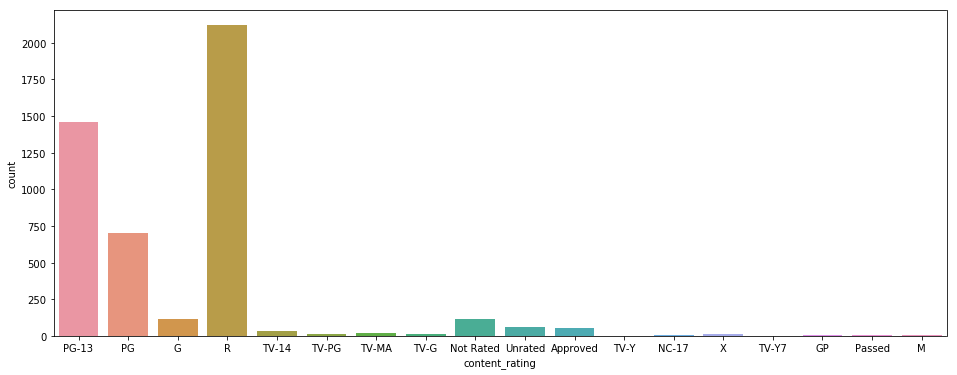

In [10]:
plt.figure(figsize=(16, 6))
sns.countplot(imdb['content_rating'])
plt.show()

In [11]:
def rating_classifier(column):
        if column == 'R':
            return column
        elif column == 'PG-13':
            return column
        elif column == 'PG':
            return column
        elif column == 'G':
            return column
        else:
            return 'misc'

imdb['content_rating'] = imdb['content_rating'].apply(rating_classifier)

In [12]:
dummy_df = pd.get_dummies(imdb['content_rating'], prefix= 'rating',drop_first=True)
imdb = pd.concat([imdb, dummy_df], axis = 1)
imdb.drop('content_rating', axis = 1, inplace = True)

### Multicollinearity test: Removing predictors that are highly correlated with eath other

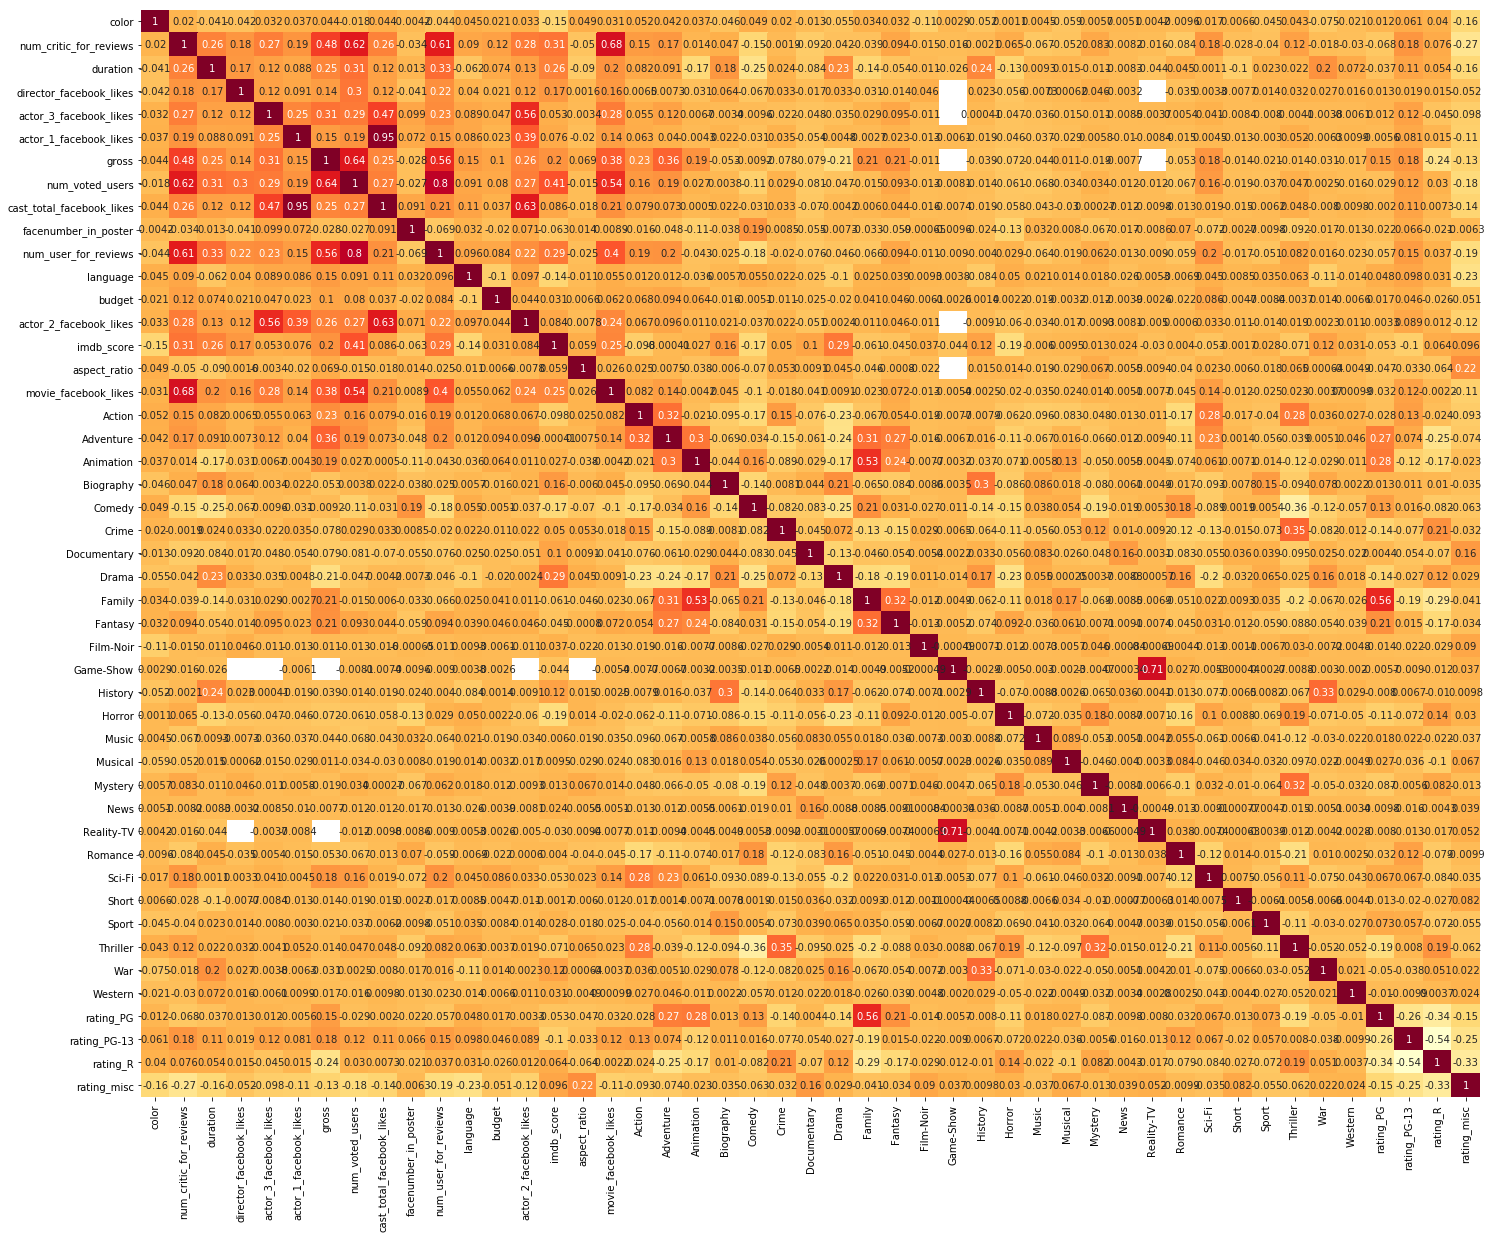

In [13]:
plt.figure(figsize = (24,20))
sns.heatmap(imdb.corr(), cmap = 'YlOrRd', cbar = False, annot=True)
plt.show()

** The heatmap reveals that the following features are highly correlated with each other: **
* num_critic_for_reviews & movie_facebook_likes
* cast_total_facebook_likes & actor_1_facebook_likes
* num_user_for_reviews & num_voted_users    
* Game-Show & Reality-TV

** So one of the the predictors for each correlated pair will be removed **

In [14]:
imdb.drop(['num_critic_for_reviews', 'cast_total_facebook_likes', 'num_user_for_reviews', 'Game-Show'], axis = 1, inplace = True)

### Removing the null values

In [15]:
imdb.dropna(inplace = True)

# Exploratory Data Analysis

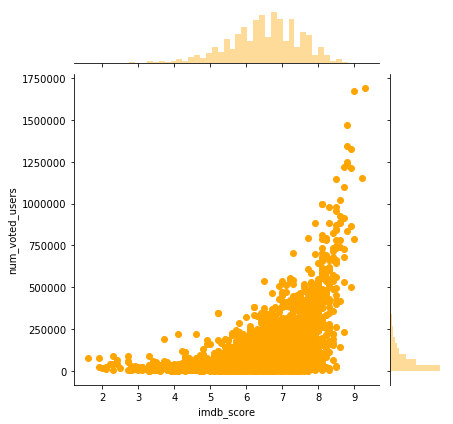

In [58]:
plt.figure(figsize=(12, 8))
sns.jointplot(data = imdb, x = 'imdb_score', y = 'num_voted_users', color = 'orange')
plt.show()

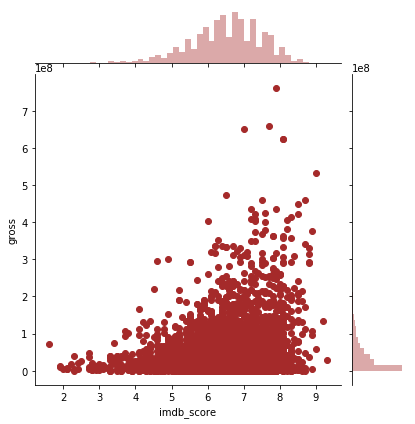

In [59]:
plt.figure(figsize=(12, 8))
sns.jointplot(data = imdb, x = 'imdb_score', y = 'gross', color = 'brown', kind = 'scatter')
plt.show()

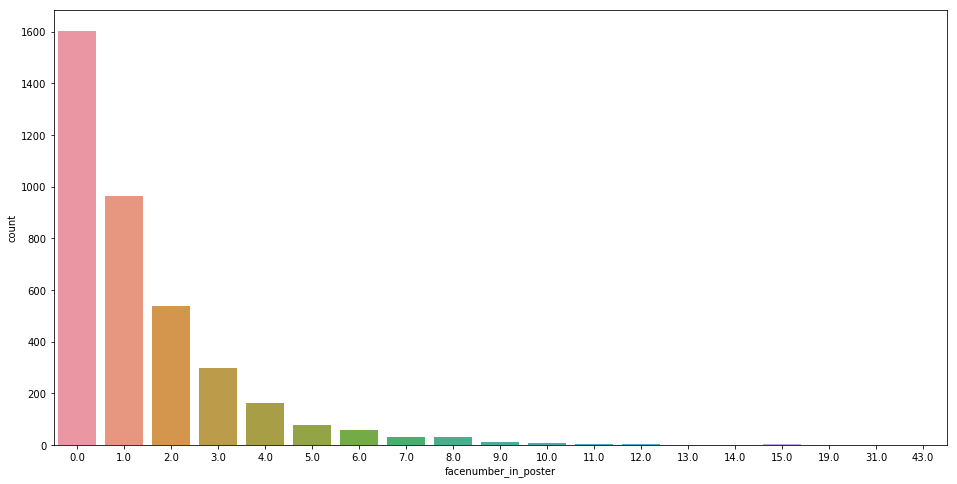

In [60]:
plt.figure(figsize=(16, 8))
sns.countplot(data = imdb, x = 'facenumber_in_poster')
plt.show()

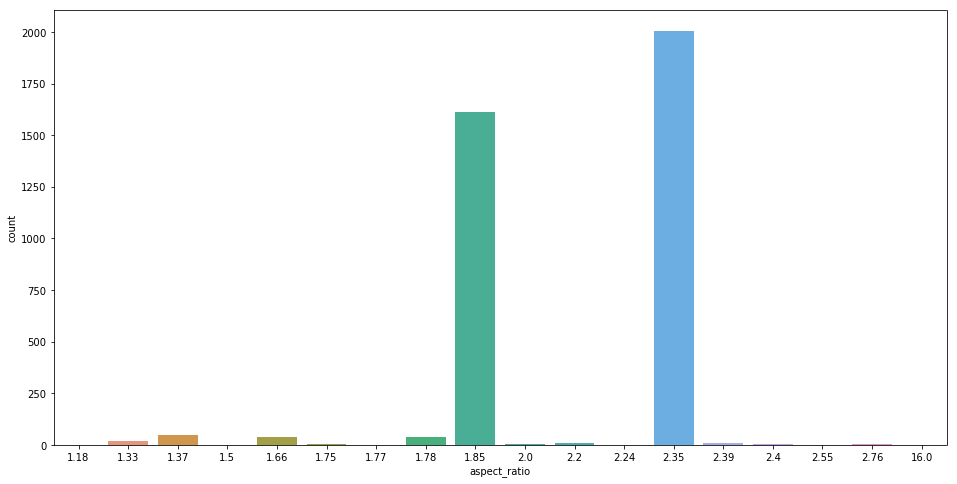

In [61]:
plt.figure(figsize=(16, 8))
sns.countplot(data = imdb, x = 'aspect_ratio')
plt.show()

### Train test split

In [20]:
x = imdb[['color', 'duration', 'director_facebook_likes',
       'actor_3_facebook_likes', 'actor_1_facebook_likes', 'gross',
       'num_voted_users', 'facenumber_in_poster', 'language', 'budget',
       'actor_2_facebook_likes', 'aspect_ratio',
       'movie_facebook_likes', 'Action', 'Adventure', 'Animation', 'Biography',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy',
       'Film-Noir', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News',
       'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 'Sport', 'Thriller', 'War',
       'Western', 'rating_PG', 'rating_PG-13', 'rating_R', 'rating_misc']]
y = imdb['imdb_score']

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

# Linear Regression

In [22]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [23]:
y_pred = lm.predict(X_test)

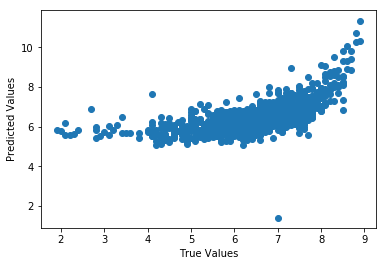

In [24]:
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()

In [25]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 0.589315042933
MSE: 0.667928722911
RMSE: 0.817269063963


### Checking for the normality of residuals

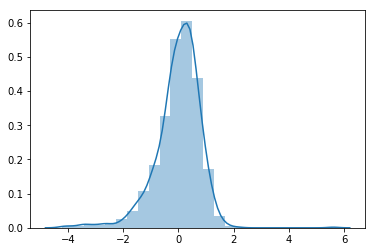

In [26]:
sns.distplot([y_test-y_pred], bins = 25)
plt.show()

# Decision Tree

In [27]:
from sklearn.tree import DecisionTreeRegressor
tree = DecisionTreeRegressor()
tree.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [28]:
y_pred = tree.predict(X_test)

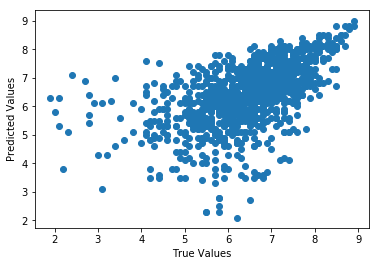

In [29]:
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()

In [30]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 0.734092900964
MSE: 1.04261174408
RMSE: 1.02108361268


# Random Forest

In [31]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=2000)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [32]:
y_pred = rf.predict(X_test)

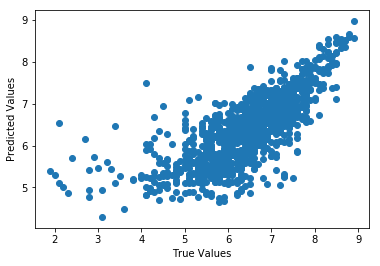

In [33]:
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()

In [34]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 0.49832537248
MSE: 0.496965482035
RMSE: 0.704957787414


# K-Nearest Neighbors

In [35]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor()
knn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform')

In [36]:
y_pred = knn.predict(X_test)

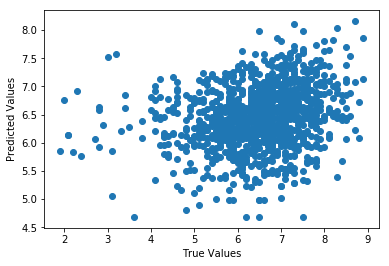

In [37]:
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()

In [38]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 0.826818580193
MSE: 1.18019281332
RMSE: 1.08636679502


# Prediction using Deep Learning

### Creating feature columns

In [39]:
for each in imdb.columns:
    'imdb_' + each + ' = '+ 'tf.feature_column.numeric_column(' + '"' + each + '"' + ')'

In [40]:
imdb_color = tf.feature_column.numeric_column("color")
imdb_duration = tf.feature_column.numeric_column("duration")
imdb_director_facebook_likes = tf.feature_column.numeric_column("director_facebook_likes")
imdb_actor_3_facebook_likes = tf.feature_column.numeric_column("actor_3_facebook_likes")
imdb_actor_1_facebook_likes = tf.feature_column.numeric_column("actor_1_facebook_likes")
imdb_gross = tf.feature_column.numeric_column("gross")
imdb_num_voted_users = tf.feature_column.numeric_column("num_voted_users")
imdb_facenumber_in_poster = tf.feature_column.numeric_column("facenumber_in_poster")
imdb_language = tf.feature_column.numeric_column("language")
imdb_budget = tf.feature_column.numeric_column("budget")
imdb_actor_2_facebook_likes = tf.feature_column.numeric_column("actor_2_facebook_likes")
imdb_imdb_score = tf.feature_column.numeric_column("imdb_score")
imdb_aspect_ratio = tf.feature_column.numeric_column("aspect_ratio")
imdb_movie_facebook_likes = tf.feature_column.numeric_column("movie_facebook_likes")
imdb_Action = tf.feature_column.numeric_column("Action")
imdb_Adventure = tf.feature_column.numeric_column("Adventure")
imdb_Animation = tf.feature_column.numeric_column("Animation")
imdb_Biography = tf.feature_column.numeric_column("Biography")
imdb_Comedy = tf.feature_column.numeric_column("Comedy")
imdb_Crime = tf.feature_column.numeric_column("Crime")
imdb_Documentary = tf.feature_column.numeric_column("Documentary")
imdb_Drama = tf.feature_column.numeric_column("Drama")
imdb_Family = tf.feature_column.numeric_column("Family")
imdb_Fantasy = tf.feature_column.numeric_column("Fantasy")
imdb_Film_Noir = tf.feature_column.numeric_column("Film-Noir")
imdb_History = tf.feature_column.numeric_column("History")
imdb_Horror = tf.feature_column.numeric_column("Horror")
imdb_Music = tf.feature_column.numeric_column("Music")
imdb_Musical = tf.feature_column.numeric_column("Musical")
imdb_Mystery = tf.feature_column.numeric_column("Mystery")
imdb_News = tf.feature_column.numeric_column("News")
imdb_Reality_TV = tf.feature_column.numeric_column("Reality-TV")
imdb_Romance = tf.feature_column.numeric_column("Romance")
imdb_SciFi = tf.feature_column.numeric_column("Sci-Fi")
imdb_Short = tf.feature_column.numeric_column("Short")
imdb_Sport = tf.feature_column.numeric_column("Sport")
imdb_Thriller = tf.feature_column.numeric_column("Thriller")
imdb_War = tf.feature_column.numeric_column("War")
imdb_Western = tf.feature_column.numeric_column("Western")
imdb_rating_PG = tf.feature_column.numeric_column("rating_PG")
imdb_rating_PG13 = tf.feature_column.numeric_column("rating_PG-13")
imdb_rating_R = tf.feature_column.numeric_column("rating_R")
imdb_rating_misc = tf.feature_column.numeric_column("rating_misc")

In [41]:
feat_cols = [imdb_color, imdb_duration,imdb_director_facebook_likes, imdb_actor_3_facebook_likes, imdb_actor_1_facebook_likes,
            imdb_gross, imdb_num_voted_users, imdb_facenumber_in_poster, imdb_language, imdb_budget, imdb_actor_2_facebook_likes,
            imdb_aspect_ratio, imdb_movie_facebook_likes, imdb_Action, imdb_Adventure, imdb_Animation, imdb_Biography, 
            imdb_Comedy, imdb_Crime, imdb_Documentary, imdb_Drama, imdb_Family, imdb_Fantasy, imdb_Film_Noir,
            imdb_History, imdb_Horror, imdb_Music, imdb_Musical, imdb_Mystery, imdb_News, imdb_Reality_TV, imdb_Romance, 
            imdb_SciFi, imdb_Short, imdb_Sport, imdb_Thriller, imdb_War, imdb_Western, imdb_rating_PG, imdb_rating_PG13,
            imdb_rating_R, imdb_rating_misc]

### Standardizing the data

In [42]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [43]:
X_train = pd.DataFrame(data = scaler.transform(X_train), 
                       columns=X_train.columns,
                       index = X_train.index)

X_test = pd.DataFrame(data = scaler.transform(X_test), 
                       columns=X_test.columns,
                       index = X_test.index)

## Prediction using Dense Neural Network

In [44]:
input_func = tf.estimator.inputs.pandas_input_fn(x = X_train, y = y_train, batch_size=10, num_epochs=1000, shuffle=True)

In [63]:
model = tf.estimator.DNNRegressor(hidden_units=[42, 10, 10], feature_columns=feat_cols)

In [66]:
model.train(input_fn=input_func, steps = 1000)

In [47]:
test_input_fn = tf.estimator.inputs.pandas_input_fn(x= X_test, batch_size=10, num_epochs=1, shuffle=False)

In [67]:
predictions = list(model.predict(test_input_fn))
y_pred = [pred['predictions'] for pred in predictions]

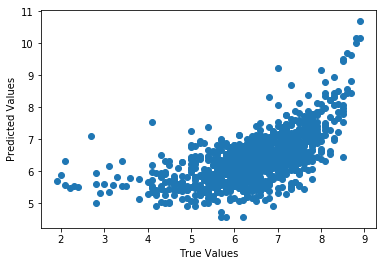

In [68]:
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()

In [69]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 0.614800003513
MSE: 0.695832642903
RMSE: 0.834165836571


## Prediction using Tensorflow's Linear Regression Estimator

In [64]:
reg_estimator = tf.estimator.LinearRegressor(feature_columns=feat_cols)

In [52]:
input_func = tf.estimator.inputs.pandas_input_fn(x = X_train, y = y_train, batch_size=6, num_epochs=1000, shuffle=True)

In [70]:
reg_estimator.train(input_func, steps = 4000)

In [54]:
input_test_func = tf.estimator.inputs.pandas_input_fn(x = X_test, batch_size=6, num_epochs=1, shuffle=False)

In [71]:
pred = list(reg_estimator.predict(input_test_func))
y_pred = [each['predictions'] for each in pred]

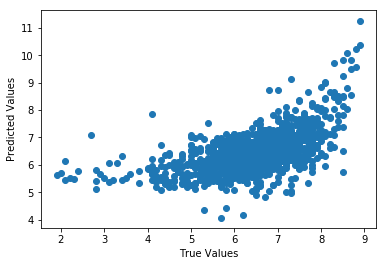

In [72]:
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()

In [73]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 0.649438455249
MSE: 0.764961656884
RMSE: 0.874620864651
